## Introduction
In this workflow, heatmap visualization for enriched pathways will be performed.

## R environment setup


In [1]:
# check if libraries are already installed > otherwise install it
if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")
if(!"RColorBrewer" %in% installed.packages()) BiocManager::install("RColorBrewer")  
if(!"dplyr" %in% installed.packages()) BiocManager::install("dplyr")
if(!"pheatmap" %in% installed.packages()) BiocManager::install("pheatmap")

#loading installed libraries
library(RColorBrewer) 
library(dplyr) 
library (pheatmap)


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org
Bioconductor version 3.10 (BiocManager 1.30.20), R 3.6.1 (2019-07-05)
Installing package(s) 'pheatmap'


package 'pheatmap' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\duygu\AppData\Local\Temp\RtmpeC2HYQ\downloaded_packages


Old packages: 'askpass', 'backports', 'BH', 'bit', 'boot', 'brio', 'broom',
  'cachem', 'callr', 'caret', 'class', 'cli', 'clipr', 'cluster', 'codetools',
  'colorspace', 'commonmark', 'crayon', 'curl', 'data.table', 'dbplyr',
  'dichromat', 'diffobj', 'digest', 'dplyr', 'evaluate', 'fansi', 'fastmap',
  'forcats', 'foreach', 'formatR', 'fs', 'generics', 'gert', 'ggplot2',
  'glmnet', 'glue', 'gower', 'gtable', 'haven', 'hexbin', 'highr', 'hms',
  'htmltools', 'htmlwidgets', 'httpuv', 'ipred', 'IRdisplay', 'IRkernel',
  'iterators', 'jsonlite', 'KernSmooth', 'knitr', 'labeling', 'later',
  'lattice', 'lava', 'lme4', 'lmtest', 'lubridate', 'magrittr', 'maps',
  'markdown', 'MASS', 'Matrix', 'mgcv', 'mime', 'minqa', 'ModelMetrics',
  'modelr', 'nlme', 'nloptr', 'nnet', 'numDeriv', 'openssl', 'pbdZMQ',
  'pillar', 'pkgconfig', 'plyr', 'prettyunits', 'processx', 'prodlim',
  'progress', 'promises', 'ps', 'purrr', 'quantmod', 'quantreg', 'R6', 'ragg',
  'RColorBrewer', 'Rcpp', 'RcppEigen', 


##  Enriched pathway list will be imported.


In [2]:
##Obtain data from step 3:
setwd('..')

#we have four datasets in total
#read all pathway lists
CD.ileum <- read.delim("4-pathway_analysis/output/enrichResults_ORA_CD_ileum.tsv",sep = "\t", header = TRUE)
CD.rectum <- read.delim("4-pathway_analysis/output/enrichResults_ORA_CD_rectum.tsv", sep = "\t",header = TRUE)
UC.ileum <- read.delim("4-pathway_analysis/output/enrichResults_ORA_UC_ileum.tsv",sep = "\t", header = TRUE)
UC.rectum <- read.delim("4-pathway_analysis/output/enrichResults_ORA_UC_rectum.tsv", sep = "\t",header = TRUE)

# Set Working Directory back to current folder
setwd("5-create_heatmap")

#we need to get pathways that has p.adjust value lower than 0.05 and qvalue<0.02
#To prevent high false discovery rate (FDR) in multiple testing, q-values are also estimated for FDR control.
CD.ileum.f <- CD.ileum[(CD.ileum$p.adjust<0.05)&(CD.ileum$qvalue<0.02),]
CD.rectum.f <- CD.rectum[(CD.rectum$p.adjust<0.05)&(CD.rectum$qvalue<0.02),]
UC.ileum.f <- UC.ileum[(UC.ileum$p.adjust<0.05)&(UC.ileum$qvalue<0.02),]
UC.rectum.f <- UC.rectum[(UC.rectum$p.adjust<0.05)&(UC.rectum$qvalue<0.02),]


## Merge all pathways into a pathway data frame


In [3]:
#Filter out unused columns 
CD.ileum.f  <- CD.ileum.f [,c(2,6)]
CD.rectum.f <- CD.rectum.f [,c(2,6)]
UC.ileum.f  <- UC.ileum.f [,c(2,6)]
UC.rectum.f <- UC.rectum.f [,c(2,6)]

#first 20 max value of p.adjust pathways for each comparison: Note that if a dataset has less then 20 sign. changed PWs, less rows need to be selected (e.g. adapt c(1:20))
#merge CD pathways
all.pathways.1 <- merge(CD.ileum.f[c(1:20),], CD.rectum.f[c(1:20),],by.x="Description", by.y="Description",sort = TRUE, all.x = TRUE, all.y = TRUE)
#merge UC pathways
all.pathways.2 <- merge(UC.ileum.f, UC.rectum.f[c(1:20),],by.x="Description", by.y="Description",sort = TRUE, all.x = TRUE, all.y = TRUE)
#merge all of them
all.pathways <- merge(all.pathways.1 , all.pathways.2 ,by.x="Description", by.y="Description",sort = TRUE, all.x = TRUE, all.y = TRUE)
colnames(all.pathways) <- c("Description","CD.ileum.p.adjust","CD.rectum.p.adjust","UC.ileum.p.adjust","UC.rectum.p.adjust")
#remove unused variables
rm(all.pathways.1, all.pathways.2)



## Modify merged pathway list


In [4]:
#replace NA values with the values from the whole list
#### for CD ileum
#find pathways which does not occur in the filtered enriched pathway list of cd.ileum (p.adjust<0.05 & qvalue<0.02 )
#because we will not take into account not sig. enriched pathways, we will assign value of 1 for their p.adjust
notExist.CDileum <- setdiff(all.pathways$Description,CD.ileum.f$Description)
all.pathways[all.pathways$Description %in% notExist.CDileum,]$CD.ileum.p.adjust <- 1

#the rest NA values correspond to the sig.enriched pathways but not in the first 20 list.
#so we will replace NA values with the p.adjust values from the whole list
NA.indices <- which(is.na(all.pathways$CD.ileum.p.adjust), arr.ind = TRUE)
allIDs <- all.pathways[NA.indices,]$Description
df <- CD.ileum.f[CD.ileum.f$Description %in% allIDs,]
df <- df[order(df$Description),]
all.pathways[all.pathways$Description %in% df$Description,]$CD.ileum.p.adjust <- df$p.adjust

#### for CD rectum
#find pathways which does not occur in the filtered enriched pathway list of cd rectum (p.adjust<0.05 & qvalue<0.02 )
notExist.CDrectum<- setdiff(all.pathways$Description,CD.rectum.f$Description)
all.pathways[all.pathways$Description %in% notExist.CDrectum,]$CD.rectum.p.adjust <- 1

#replacing NA values with the values from the whole list
NA.indices <- which(is.na(all.pathways$CD.rectum.p.adjust), arr.ind = TRUE)
allIDs <- all.pathways[NA.indices,]$Description
df <- CD.rectum.f[CD.rectum.f$Description %in% allIDs,]
df <- df[order(df$Description),]
all.pathways[all.pathways$Description %in% df$Description,]$CD.rectum.p.adjust <- df$p.adjust

#### for UC ileum
#find pathways which does not occur in the filtered enriched pathway list of UC ileum (p.adjust<0.05 & qvalue<0.02 )
notExist.UCileum <- setdiff(all.pathways$Description,UC.ileum.f$Description)
all.pathways[all.pathways$Description %in% notExist.UCileum,]$UC.ileum.p.adjust <- 1

#### for UC rectum
#find pathways which does not occur in the filtered enriched pathway list of UC rectum (p.adjust<0.05 & qvalue<0.02 )
notExist.UCrectum<- setdiff(all.pathways$Description,UC.rectum.f$Description)
all.pathways[all.pathways$Description %in% notExist.UCrectum,]$UC.rectum.p.adjust <- 1

#replacing NA values with the values from the whole list
NA.indices <- which(is.na(all.pathways$UC.rectum.p.adjust), arr.ind = TRUE)
allIDs <- all.pathways[NA.indices,]$Description
df <- UC.rectum.f[UC.rectum.f$Description %in% allIDs,]
df <- df[order(df$Description),]
all.pathways[all.pathways$Description %in% df$Description,]$UC.rectum.p.adjust <- df$p.adjust



## Heatmap visualization


png 
  2

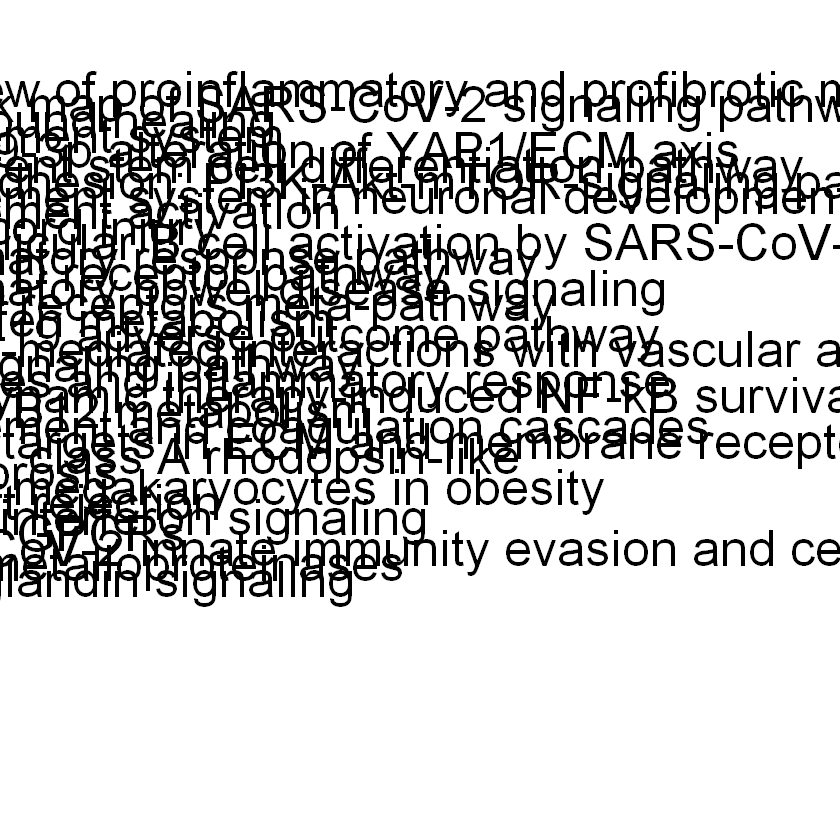

In [5]:
#take only required columns
row.names(all.pathways) <- all.pathways$Description
all.pathways  <- all.pathways[,2:5]
colnames(all.pathways) <- c("CD.ileum","CD.rectum","UC.ileum","UC.rectum")

#create output folder if not exist
if(!dir.exists("output")) dir.create("output")

## Select a size to visualize the heatmap with (options; large or small)
size_heatmap <- "large"

##Print labels large for paper, small for notebook:
fontsize_row_l = 30 
if (size_heatmap == "large") {
fontsize_col_l = 30 
fontsize_l = 30
width_l =2000 
height_l =2000 
name_heatmap_file <- "output/heatmap_log10_large.png"
}else if(size_heatmap == "small"){ 
fontsize_row_l = 10 
fontsize_col_l = 10 
width_l =1500 
height_l =1500 
fontsize_l = 10
name_heatmap_file <- "output/heatmap_log10_small.png"
}else{print("Size not Recognised")}

#normally darker value represent higher values light color represent smaller values
#when we use rev function higher ones are represented by light color
colMain <- colorRampPalette(rev(brewer.pal(9, "Blues")))(30)

my_heatmap <- pheatmap(as.matrix(log10(all.pathways)), scale = "none", color = colMain , 
                       legend = TRUE , legend_breaks = c(0, -5, -10, -15, min(log10(all.pathways))), 
                       main = "", 
                       legend_labels = c("adj. p-values \n", " -5", " -10", " -15", ""),
                       cellwidth = 80, treeheight_row = 200, fontsize = fontsize_l, fontsize_row= fontsize_row_l, 
                       fontsize_col = fontsize_col_l, cluster_rows = TRUE, cluster_cols = FALSE)
                      
#save obtained heatmap
save_pheatmap_png <- function(x, filename, width = width_l, height = height_l) {
  png(filename, width = width, height = height)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}
##p-values are visalized on a log10 scale, to make them more discriminatory.
save_pheatmap_png(my_heatmap, name_heatmap_file)



##Print session info and remove large datasets:


In [6]:
##Print session info:
sessionInfo()

##Remove data objects which are not needed for further processing:
rm(list=setdiff(ls(), "all.pathways"))


R version 3.6.1 (2019-07-05)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19044)

Matrix products: default

locale:
[1] LC_COLLATE=English_Netherlands.1252  LC_CTYPE=English_Netherlands.1252   
[3] LC_MONETARY=English_Netherlands.1252 LC_NUMERIC=C                        
[5] LC_TIME=English_Netherlands.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] pheatmap_1.0.12    dplyr_0.8.0.1      RColorBrewer_1.1-2

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.1          magrittr_1.5        munsell_0.5.0      
 [4] tidyselect_0.2.5    uuid_0.1-2          colorspace_1.4-1   
 [7] R6_2.4.0            rlang_0.4.11        tools_3.6.1        
[10] grid_3.6.1          gtable_0.3.0        htmltools_0.3.6    
[13] digest_0.6.18       assertthat_0.2.1    tibble_2.1.1       
[16] crayon_1.3.4        IRdisplay_0.7.0     BiocManager_1.30.20
[19] purrr_0.3.2         repr_0.1


## Last, we create a Jupyter notebook from this script


In [ ]:
#Jupyter Notebook file
if(!"devtools" %in% installed.packages()) BiocManager::install("devtools")
devtools::install_github("mkearney/rmd2jupyter", force=TRUE)
library(devtools)
library(rmd2jupyter)
rmd2jupyter("heatMap.Rmd")
